In [2]:
# TensorFlow と tf.keras のインポート
import tensorflow as tf
from tensorflow import keras
%tensorflow_version 2.x


# Xceptionモデルを利用して転移学習しよう

## データをインポートしよう（画像サイズのみ変更）

In [3]:
import cv2
import numpy as np
import os
from glob import glob

Path = glob("/content/drive/My Drive/Colab Notebooks/face/*/")

# 空のリストを準備
data = []
label = [] 
class_num = 0

# 画像サイズ
image_size = 150

def append_data(directory, class_num):
    # 例：['KA.AN2.40.jpg', 'KA.AN3.41.jpg',,,,,'KL.AN2.168.jpg', 'KL.AN3.169.jpg']
    files = os.listdir(directory)  # ディレクトリの中をファイルを全てリストにする
    print(files)
    for image in files:
        if image.endswith(".jpg"): # jpg画像だけを抽出
            image = cv2.imread(directory + image) # 画像を準備
            image = cv2.resize(image, (image_size, image_size)) # リサイズ
            # image_gs = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # グレースケール
            image = image.flatten() # リストを平坦化     
            data.append(image)  # 学習用データに代入
            label.append(class_num)  # 学習用データのラベルに代入
                
for fil in Path:
    append_data(fil, class_num)
    class_num += 1

print(label)

['TM.HA2.181.jpg', 'KL.HA2.159.jpg', 'YM.HA2.53.jpg', 'MK.HA1.116.jpg', 'KM.NE1.1.jpg', 'MK.HA3.118.jpg', 'MK.HA2.117.jpg', 'NA.HA2.203.jpg', 'YM.HA3.54.jpg', 'NA.HA3.204.jpg', 'KR.HA1.74.jpg', 'NA.HA1.202.jpg', 'TM.HA3.182.jpg', 'UY.HA2.138.jpg', 'UY.HA3.139.jpg', 'NM.HA1.95.jpg', 'TM.HA1.180.jpg', 'KM.HA1.4.jpg', 'KA.HA3.31.jpg', 'KM.HA2.5.jpg', 'KM.HA4.7.jpg', 'KM.HA3.6.jpg', 'KR.HA2.75.jpg', 'KL.HA3.160.jpg', 'YM.HA1.52.jpg', 'NM.HA3.97.jpg', 'KA.HA4.32.jpg', 'UY.HA1.137.jpg', 'KL.HA1.158.jpg', 'KA.HA2.30.jpg', 'KA.HA1.29.jpg', 'NM.HA2.96.jpg']
['KA.AN1.39.jpg', 'KM.AN2.18.jpg', 'NA.AN2.212.jpg', 'NM.AN3.106.jpg', 'NA.AN1.211.jpg', 'TM.AN1.190.jpg', 'NM.AN2.105.jpg', 'KL.AN3.169.jpg', 'TM.AN3.192.jpg', 'KR.AN3.85.jpg', 'KA.AN2.40.jpg', 'UY.AN2.147.jpg', 'NM.AN1.104.jpg', 'YM.AN2.62.jpg', 'MK.AN2.126.jpg', 'KL.AN2.168.jpg', 'MK.AN3.127.jpg', 'KR.AN2.84.jpg', 'UY.AN3.148.jpg', 'KL.AN1.167.jpg', 'KA.AN3.41.jpg', 'MK.AN1.125.jpg', 'KM.AN3.19.jpg', 'NA.AN3.213.jpg', 'UY.AN1.146.jpg', 'K

## CNNに適用する型に変更（501と同じ）

In [4]:
# データ型の変換
data = np.array(data, dtype=np.float32)
label = np.array(label, dtype=np.float32)

# 学習データとテストデータに分割
from sklearn.model_selection import train_test_split
train_data, test_data, train_label, test_label = train_test_split(data,label, 
                                                                  random_state = 1, 
                                                                  stratify = label, 
                                                                  test_size = 0.2)

# 学習データのリストを変形  #.reshape(データの数, 縦のサイズ, 横のサイズ, 次元)
train_data = train_data.reshape((len(train_data)),image_size,image_size,3)
test_data = test_data.reshape((len(test_data)),image_size,image_size,3)

# 学習データを正規化
train_data /= 255 # to 0-1
test_data /= 255 # to 0-1

# ラベルデータをone-hot 変換
from keras.utils.np_utils import to_categorical
train_label = to_categorical(train_label, num_classes=5)
test_label = to_categorical(test_label, num_classes=5)

print(train_data.shape, train_label.shape, test_data.shape, test_label.shape) 

# test_label


(121, 150, 150, 3) (121, 5) (31, 150, 150, 3) (31, 5)


Using TensorFlow backend.


# Xceptionモデルをインポート

In [5]:
#モデル作成・学習
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Input
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation,GlobalAveragePooling2D,Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers

base_model = Xception(include_top = False,
                      weights = "imagenet",
                      input_shape = None)

# 全結合層の新規構築
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(5, activation = 'softmax')(x)

# ネットワーク定義
X_model = Model(inputs = base_model.input, outputs = predictions)
print("{}層".format(len(X_model.layers)))

#123層までfreeze
for layer in X_model.layers[:123]:
    layer.trainable = False

    # Batch Normalization の freeze解除
    if layer.name.startswith('batch_normalization'):
        layer.trainable = True
    if layer.name.endswith('bn'):
        layer.trainable = True

#124層以降、学習させる
for layer in X_model.layers[123:]:
    layer.trainable = True

# layer.trainableの設定後にcompile
X_model.compile(
    optimizer = Adam(),
    loss = 'categorical_crossentropy',
    metrics = ["accuracy"]
)


X_model.summary()

83689472/83683744 [==============================] - 1s 0us/step
135層
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
________________________

# Data Augumentation

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 5,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    horizontal_flip = True,
    vertical_flip = False
)

# 学習を実行しよう

In [7]:
epoch = 50
batchsize = 8

# 学習
history = X_model.fit_generator(datagen.flow(train_data, train_label, batch_size=batchsize),
                                epochs=epoch, verbose=2, 
                                validation_data=datagen.flow(test_data, test_label, batch_size=batchsize))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
16/16 - 4s - loss: 1.8240 - accuracy: 0.1653 - val_loss: 1.6710 - val_accuracy: 0.1935
Epoch 2/50
16/16 - 2s - loss: 1.3670 - accuracy: 0.5124 - val_loss: 3.7040 - val_accuracy: 0.1935
Epoch 3/50
16/16 - 2s - loss: 1.2708 - accuracy: 0.5207 - val_loss: 4.2570 - val_accuracy: 0.2258
Epoch 4/50
16/16 - 2s - loss: 0.9930 - accuracy: 0.6281 - val_loss: 3.7021 - val_accuracy: 0.2581
Epoch 5/50
16/16 - 2s - loss: 0.7644 - accuracy: 0.7355 - val_loss: 2.4906 - val_accuracy: 0.2581
Epoch 6/50
16/16 - 2s - loss: 0.8661 - accuracy: 0.6860 - val_loss: 5.6207 - val_accuracy: 0.3871
Epoch 7/50
16/16 - 2s - loss: 0.7749 - accuracy: 0.7273 - val_loss: 3.0478 - val_accuracy: 0.3548
Epoch 8/50
16/16 - 2s - loss: 0.7232 - accuracy: 0.6942 - val_loss: 3.8505 - val_accuracy: 0.2903
Epoch 9/50
16/16 - 2s - loss: 0.6739 - accuracy: 0.7769 - val_loss: 3.9231 - val_accuracy: 0.2903
Epoch 10/50
16/16 - 2s - loss: 0.7162 - ac

## 結果を可視化しよう 

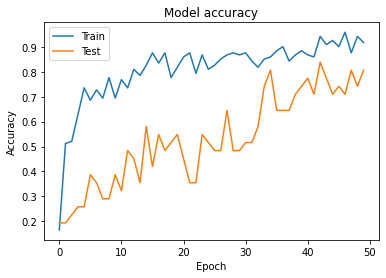

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')

plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

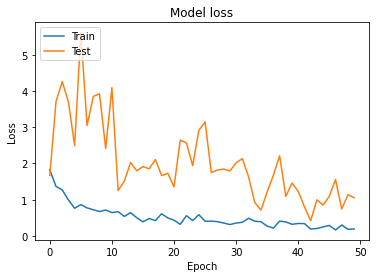

In [9]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [10]:
#モデルの保存
X_model.save('/content/drive/My Drive/Colab Notebooks/Xweights.h5')

# 追加学習をしよう

In [11]:
# 学習済みモデルを読み込み
load_model =keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Xweights.h5')

In [12]:
# 追加学習
history = load_model.fit(train_data, train_label,
                         epochs=50, verbose=1, 
                         validation_data=(test_data, test_label))


Epoch 1/50
4/4 [==============================] - 5s 1s/step - loss: 0.0496 - accuracy: 0.9917 - val_loss: 1.0019 - val_accuracy: 0.7742
Epoch 2/50
4/4 [==============================] - 1s 286ms/step - loss: 0.0424 - accuracy: 0.9917 - val_loss: 0.9612 - val_accuracy: 0.8065
Epoch 3/50
4/4 [==============================] - 1s 286ms/step - loss: 0.0371 - accuracy: 1.0000 - val_loss: 0.9073 - val_accuracy: 0.8065
Epoch 4/50
4/4 [==============================] - 1s 284ms/step - loss: 0.0273 - accuracy: 0.9917 - val_loss: 0.8599 - val_accuracy: 0.8387
Epoch 5/50
4/4 [==============================] - 1s 286ms/step - loss: 0.0209 - accuracy: 1.0000 - val_loss: 0.8146 - val_accuracy: 0.8710
Epoch 6/50
4/4 [==============================] - 1s 284ms/step - loss: 0.0165 - accuracy: 0.9917 - val_loss: 0.7788 - val_accuracy: 0.8710
Epoch 7/50
4/4 [==============================] - 1s 287ms/step - loss: 0.0158 - accuracy: 1.0000 - val_loss: 0.7538 - val_accuracy: 0.8710
Epoch 8/50
4/4 [=======

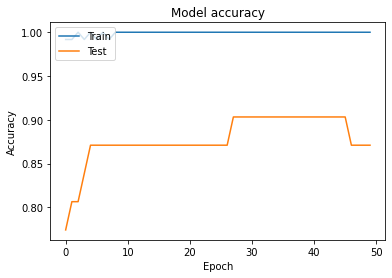

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')

plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


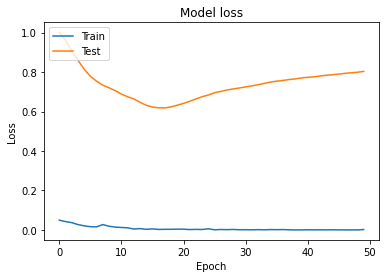

In [14]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
